# Anomalous diffusion
Diffusion processes are mostly used to describe the random motion of particles in fluids, but also apply to biological systems, like animals that search for food or cancer cells migrating through tissue. In an experimental setup, we may simply track the random motions of a particle/animal/cell over time and thereby use it as a probe to measure the diffusion coefficient of the fluid/habitat/tissue. However, by averaging over all measured movements, one may loose important information, as the diffusion coefficient may change over time or depending on the current position of the probe. Changes in the diffusion coefficient may be externally triggered, e.g. by a change in temperature for diffusing particles or a change in terrain within the foraging habitat of an animal. Furthermore, changes in diffusivity may be internally triggered, e.g. by the cell cycle of an invading cancer cell. Here, we present two examples of anomalous diffusion, one with a gradually changing diffusivity, and one with discrete regions of varying diffusivity.

## Diffusion gradient
Suppose we have a diffusion gradient, for example due to a temperature gradient across our sample, and we want to determine the diffusion coefficient for different positions along the axis of the gradient. To infer the spatially changing diffusion coefficient, we assume that the amplitude of the random walk of our particle changes gradually over time, as the particle moves through regions of varying diffusivity.

For this example, we assume a positive, constant diffusion gradient, resulting a linear increase of the diffusion coefficient $D$:

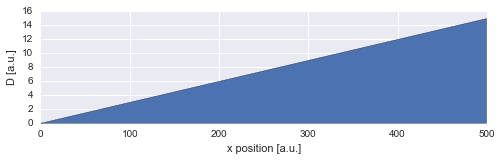

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

D = np.linspace(0.0, 15., 500)
x = np.arange(500)

plt.figure(figsize=(8,2))
plt.fill_between(x, D, 0)
plt.xlabel('x position [a.u.]')
plt.ylabel('D [a.u.]');

### Trajectory simulation
For this example, we simply simulate a random walk of a particle assuming a Gaussian random walk with the standard deviation equal to the diffusion coefficient at the current position:

In [2]:
np.random.seed(12337) # reproducable results
trajectory = [[150., 150.]] # starting point

for t in range(750):
    try:
        dc = D[int(trajectory[-1][0])] # look up diffusion coefficient
    except:
        if int(trajectory[-1][0]) >= 500: 
            dc = 15. # constant diffusion coefficient on the far right
        else:
            dc = 0. # constant diffusion coefficient on the far left
    trajectory.append([p + np.random.normal(0, dc) for p in trajectory[-1]])

trajectory = np.array(trajectory)

If we plot this simulated trajectory, we see how the distance between two subsequent positions of the particle is significantly smaller on the left as compared to the right of our diffusion gradient (visible as gray shading):

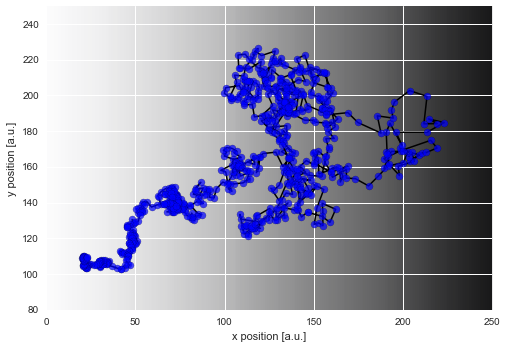

In [3]:
plt.figure(figsize=(8, 10))

D_img = np.array([list(D)]*len(D))[:, :250]
plt.imshow(D_img, cmap='Greys', alpha=0.9, zorder=0, interpolation='nearest')

plt.scatter(*trajectory.T, lw=0.2, c='b', alpha=0.7, zorder=2, s=50)
plt.plot(*trajectory.T, lw=1.5, c='k', zorder=1)
plt.xlim([0, 250])
plt.ylim([80, 250])
plt.xlabel('x position [a.u.]')
plt.ylabel('y position [a.u.]');

### Modeling
To model this example of anomalous diffusion, we first generate a low-level model - a simple Gaussian random walk - using `SymPy` random variables. Here, we simply assume that the velocity components of our particle are normally distributed, with zero mean. As we further assume that the diffusion coefficient changes gradually across our sample, our particle should also gradually change its diffusivity as it moves across the sample. We therefore also use a Gaussian random walk as the high-level model. As we do not know the amplitude of the change of diffusivity, we choose a `HyperStudy` as it enables the inference of this hyper-parameter.

In [4]:
import bayesloop as bl
import sympy.stats
from sympy import Symbol

S = bl.HyperStudy()

# load data
velocity = trajectory[1:] - trajectory[:-1] # compute velocity vectors from positions
S.load(velocity)

# create low-level model
std = Symbol('D', positive=True)
normal = sympy.stats.Normal('normal', 0, std)

# we assume the diffusivity to lie within the interval ]0, 15[
# within this interval, we create 5000 equally spaced parameter values
L = bl.om.SymPy(normal, {'D': bl.oint(0, 15, 5000)})

# create high-level model
# we assume a Gaussian random walk of the parameter 'D' with a
# standard deviation within the interval [0, 0.3] (20 equally
# spaced hyper-parameter values)
T = bl.tm.GaussianRandomWalk('sigma', bl.cint(0, 0.3, 20), target='D')

S.set(L, T)
S.fit()

+ Created new study.
  --> Hyper-study
+ Successfully imported array.
    + Trying to determine Jeffreys prior. This might take a moment...
    + Successfully determined Jeffreys prior: sqrt(2)/D. Will use corresponding lambda function.
+ Observation model: normal. Parameter(s): ['D']
+ Transition model: Gaussian random walk. Hyper-Parameter(s): ['sigma']
+ Set hyper-prior(s): ['uniform']
+ Started new fit.
    + 20 analyses to run.

    + Computed average posterior sequence
    + Computed hyper-parameter distribution
    + Log10-evidence of average model: -1583.15297
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


### Analysis

After fitting is done, we may evaluate how the diffusion coefficient of our particle changed over time by plotting the mean values of the posterior distributions (black line) together with the posterior distributions of the amplitude of the particle motions (blue shading): 

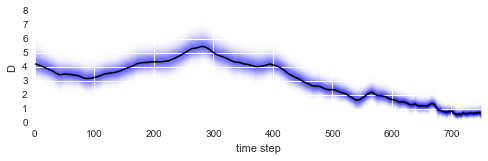

In [5]:
plt.figure(figsize=(8,2))
S.plot('D')
plt.xlim([0, 750])
plt.ylim([0, 8]);

As we can see, the diffusion coefficient changes quite irregularly over time, but this irregularity is just the result of the irregular path of our particle across the sample. However, this plots confirms that the chosen parameter boundaries of $\sigma \in [0, 20]$ suffice. We may re-plot the particle path from above, but this time color-code the particle positions with the corresponding inferred diffusivity values:

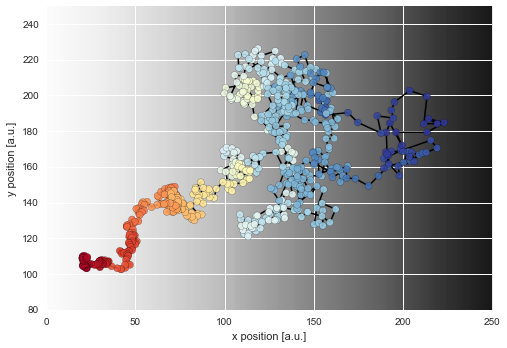

In [6]:
D_mean = S.getParameterMeanValues('D') # extract posterior mean values of first (and only) parameter

# prepare color coding
m = plt.cm.ScalarMappable(cmap='RdYlBu')
m.set_array(D_mean)
m.autoscale()

plt.figure(figsize=(8, 10))
plt.imshow(D_img, cmap='Greys', alpha=0.9, zorder=0, interpolation='nearest')
plt.scatter(*trajectory[1:].T, lw=0.2, c=[m.to_rgba(x) for x in D_mean], alpha=0.9, zorder=2, s=50)
plt.plot(*trajectory[1:].T, lw=1.5, c='k', zorder=1)
plt.xlim([0, 250])
plt.ylim([80, 250])
plt.xlabel('x position [a.u.]')
plt.ylabel('y position [a.u.]');

Finally, we can directly compare the inferred mean values to the true values of the diffusion coefficient used in the simulation:

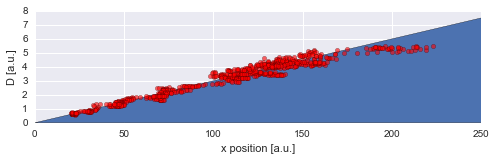

In [7]:
D = np.linspace(0.0, 15., 500)
x = np.arange(500)

plt.figure(figsize=(8,2))
plt.fill_between(x, D, 0)
plt.scatter(trajectory[1:, 0], D_mean, c='r', alpha=0.6)

plt.xlim([0, 250])
plt.ylim([0, 8])
plt.xlabel('x position [a.u.]')
plt.ylabel('D [a.u.]');

To assess our choice for the hyper-parameter boundaries, we may further plot the inferred distribution of the magnitude of parameter changes between time steps. In this case, the distribution falls off to (approximately) zero on both sides, therefore the boundaries suffice.

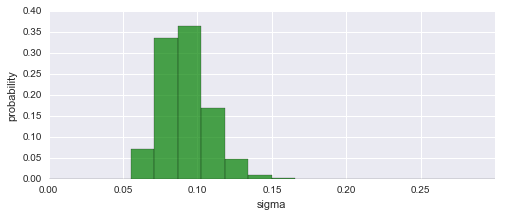

In [8]:
plt.figure(figsize=(8,3))
S.plot('sigma', alpha=0.7, facecolor='g')
plt.xlim([0, 0.3]);

## Regime-switch diffusion process

While the first example investigated gradual variations, we now turn to abrupt jumps in diffusivity, as they may occur for proteins diffusing on a cell membrane. The binding and unbinding of the protein to other constituents of the membrane may inhibit or favor diffusion. In a very simplistic attempt to model this complex process, we assume only two different regimes of diffusivity, and arrange them spatially like a chessboard pattern. On the dark patches, the diffusivity reaches three times the value as on the light patches:

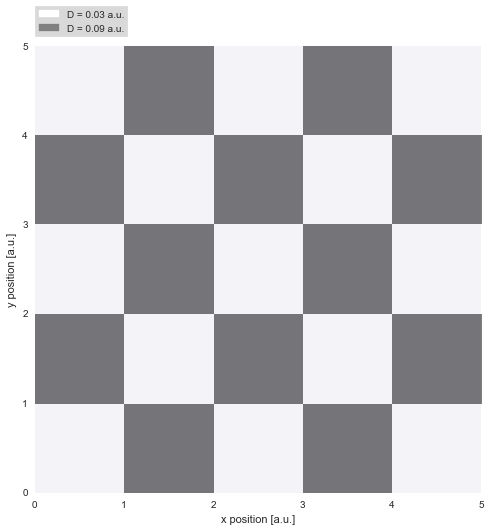

In [9]:
import matplotlib.patches as mpatches

# helper function for chessboard pattern
def check_region(x, y):
    if (int(x) % 2 == 0 and int(y) % 2 == 0) or (int(x) % 2 == 1 and int(y) % 2 == 1):
        return True
    else:
        return False

# create chessboard pattern
n = 5
D_img = np.array([0, 1]*int(np.ceil(0.5*(n**2))))[:-1].reshape([n, n])

# plot chessboard pattern
plt.figure(figsize=(8,8))
plt.imshow(D_img, cmap='Greys', alpha=0.5, extent=[0, n, 0, n], zorder=0, interpolation='nearest')
plt.grid(b=False, which='major')
plt.xlabel('x position [a.u.]')
plt.ylabel('y position [a.u.]')

# legend
white_patch = mpatches.Patch(color='white', label='D = 0.03 a.u.')
gray_patch = mpatches.Patch(color='0.5', label='D = 0.09 a.u.')
legend = plt.legend(handles=[white_patch, gray_patch], 
                    bbox_to_anchor=(0., 1.02, 1., .102), 
                    loc=3,
                    borderaxespad=0.,
                    frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('0.85')

### Trajectory simulation
Again, we simulate a random walk of a particle assuming a Gaussian random walk with the standard deviation equal to the diffusion coefficient at the current position:

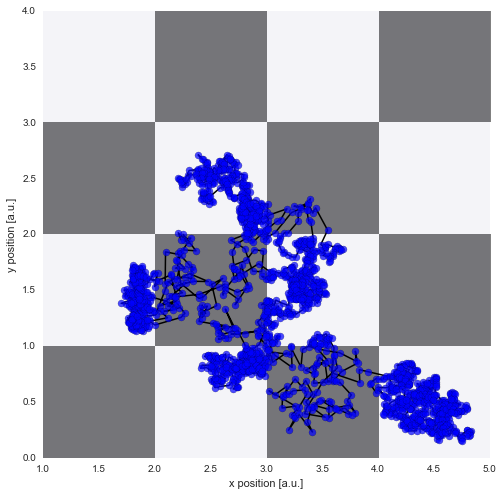

In [10]:
np.random.seed(1274)

D1 = 0.03
D2 = 0.09

trajectory = [[2.5, 2.5]]

for t in range(2000):
    dc = D1 if check_region(*trajectory[-1]) else D2
    trajectory.append([x + np.random.normal(0, dc) for x in trajectory[-1]])

trajectory = np.array(trajectory)

# plotting
plt.figure(figsize=(8,8))
plt.imshow(D_img, cmap='Greys', alpha=0.5, extent=[0, n, 0, n], zorder=0, interpolation='nearest')
plt.grid(b=False, which='major')
plt.xlabel('x position [a.u.]')
plt.ylabel('y position [a.u.]')

plt.scatter(*trajectory.T, lw=0.2, c='b', alpha=0.7, zorder=2, s=50)
plt.plot(*trajectory.T, lw=1.5, c='k', zorder=1)

plt.xlim([1, 5])
plt.ylim([0, 4]);

### Modeling
The low-level model stays the same as in the previous example, a Gaussian random walk. As the parameter changes are not gradual in this example, however, we assume a regime-switching process for the high-level model. Here, we assign a small probability to all possible parameter values in each time step to account for the rare, but possible event of a abrupt parameter change. As we do not know this minimal probability value a-priori, we again use a hyper-study to test different values. Note that we may keep our study-instance defined as above and just load new data, adjust the parameter boundaries and alter the high-level model:

In [11]:
# load new data
velocity = trajectory[1:] - trajectory[:-1]
S.load(velocity)

# change parameter boudaries of low-level model
L = bl.om.SymPy(normal, {'D': bl.oint(0, 0.2, 2000)})

# create high-level model
T = bl.tm.RegimeSwitch('log10pMin', bl.cint(-10, 3, 20))

S.set(L, T)
S.fit()

+ Successfully imported array.
    + Trying to determine Jeffreys prior. This might take a moment...
    + Successfully determined Jeffreys prior: sqrt(2)/D. Will use corresponding lambda function.
+ Observation model: normal. Parameter(s): ['D']
+ Transition model: Regime-switching model. Hyper-Parameter(s): ['log10pMin']
+ Set hyper-prior(s): ['uniform']
+ Started new fit.
    + 20 analyses to run.

    + Computed average posterior sequence
    + Computed hyper-parameter distribution
    + Log10-evidence of average model: 3236.20040
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


### Analysis

After fitting is done, we may check whether we are indeed able to detect the abrupt parameter changes over time:

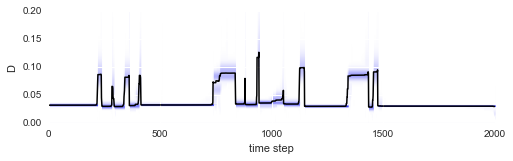

In [12]:
plt.figure(figsize=(8,2))
S.plot('D')
plt.xlim([0, 2000])
plt.ylim([0, .2]);

The irregular spacing of the parameter jumps in time gets more regular once the parameter evolution is plotted on the chessboard pattern:

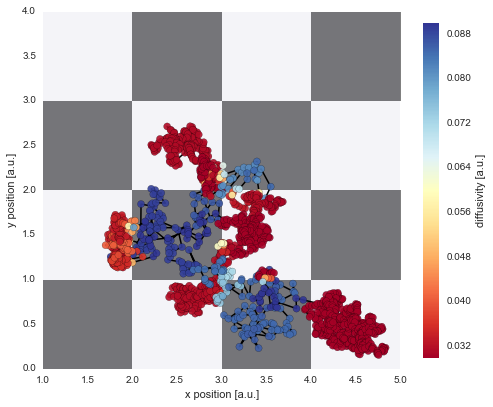

In [13]:
D_mean = S.getParameterMeanValues('D')

# prepare color coding
m = plt.cm.ScalarMappable(cmap='RdYlBu')
m.set_array([0.03, 0.09])
m.autoscale()

# plotting
plt.figure(figsize=(8,8))
plt.imshow(D_img, cmap='Greys', alpha=0.5, extent=[0, n, 0, n], zorder=0, interpolation='nearest')
plt.grid(b=False, which='major')
plt.xlabel('x position [a.u.]')
plt.ylabel('y position [a.u.]')

plt.scatter(*trajectory[1:].T, lw=0.2, c=[m.to_rgba(x) for x in D_mean], alpha=0.9, zorder=2, s=50)
plt.plot(*trajectory[1:].T, lw=1.5, c='k', zorder=1)

cb = plt.colorbar(m, shrink=0.75)
cb.set_label('diffusivity [a.u.]')
cb.set_clim(0.03, 0.09)

plt.xlim([1, 5])
plt.ylim([0, 4]);

The figure above shows that we can nicely reconstruct the spatial pattern in diffusivity for the region covered by the diffusing particle. Finally, we may plot a histogram to confirm that the inferred values for the diffusion coefficient (green histogram) align with the true values used in the simulation (red lines):

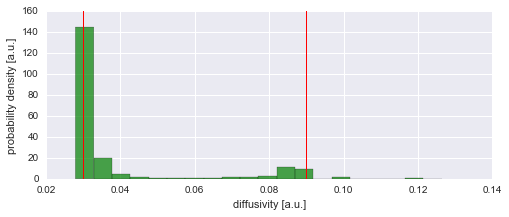

In [14]:
plt.figure(figsize=(8,3))
plt.hist(D_mean, 20, alpha=0.7, facecolor='g', normed=True)
plt.axvline(0.03, 0, 1600, lw=1, c='r')
plt.axvline(0.09, 0, 1600, lw=1, c='r')
plt.xlabel('diffusivity [a.u.]')
plt.ylabel('probability density [a.u.]');

### Model selection
In the example above, we a-priori assumed abrupt changes of the diffusion coefficient, because we knew the parameter dynamics from the simulation of our trajectory. In an experimental setup, however, one hardly knows the exact nature of the parameter dynamics before-hand. The big advantage of *bayesloop* is to compute the model evidence, i.e. the probability (density) of observing the data given the model one assumes. For a simple demonstration, we again choose the high-level model of the first example and assume gradual parameter fluctuations (we only adjust the scale for this example) and re-run the fit:

In [15]:
T = bl.tm.GaussianRandomWalk('sigma', bl.cint(0, 0.01, 20), target='D')
S.set(T)

S.fit()

+ Transition model: Gaussian random walk. Hyper-Parameter(s): ['sigma']
+ Set hyper-prior(s): ['uniform']
+ Started new fit.
    + 20 analyses to run.

    + Computed average posterior sequence
    + Computed hyper-parameter distribution
    + Log10-evidence of average model: 3206.17483
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


Here, we obtain a model evidence value of **3206** on a log$_{10}$ scale (these probability density values can get absurdly small or large if many data points are involved), compared to **3236** for the correct, regime-switching model. This means that it is **10**$^{\textbf{30}}$**-times more likely** that the 2000 data points of our trajectory are created by a regime-switching process, compared to gradual variations of the diffusion coefficient!